# Assignment 2
The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 

Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

In [1]:
# !wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
# !unzip --qq msrc_objcategimagedatabase_v1.zip

In [2]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

run_mode = 'train'

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

## Step 1: 
First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package. You are welcome to compare your own SLIC Superpixels output from assignment 1 with scikit-image SLIC output. But we would be grading the outputs in comparison to the scikit-image superpixel outputs. 

However, before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

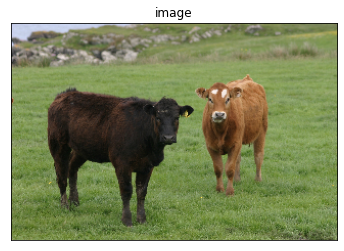

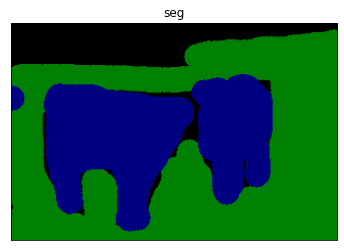

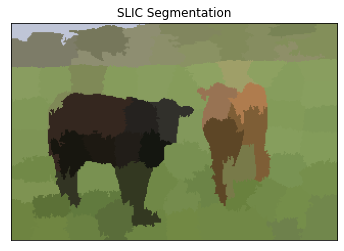

In [3]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10, start_label=1)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [4]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os
current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

In [5]:
#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
for i in SEG_LABELS_LIST_v2:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']

Suggested algorithm: Save the superpixels along with their segmentation class

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Also Suggested would be creating a single csv with columns segment patch location, class label for each sp_i of each image.<br>




In [6]:
# from IPython.display import Image
# Image(filename='data_preprocessing.png') 

In [7]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.

import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import csv

np.random.seed(10)
version="v1"

rgb_2_label = {}
SEG_LABELS_LIST = {'v1': SEG_LABELS_LIST_v1, 'v2': SEG_LABELS_LIST_v2}
for i in SEG_LABELS_LIST[version]:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']

if run_mode.lower() == 'generate':
    def patch_2_label(img: float, coord) -> int:
        
        seg_patch = img[coord[1]:coord[3], coord[0]:coord[2]]
        count = 0
        labels = np.unique(seg_patch)
        
        for label in labels:
            elements = len(np.where(seg_patch == label)[0])
            if elements > count:
                count = elements
                final_label = label
        
        return int(final_label)
        
    def seg_image_2_labels(seg_image):
        seg_image_labels = np.zeros((seg_image.shape[0], seg_image.shape[1]))
        for i in range(seg_image.shape[0]):
            for j in range(seg_image.shape[1]):
    #             print(tuple(seg_image[i][j][::-1]), tuple(seg_image[i][j]))
                try:
                    seg_image_labels[i][j] = rgb_2_label[tuple(seg_image[i][j][::-1])]
                except:
                    seg_image_labels[i][j] = -1
        
        return seg_image_labels


    if os.path.exists(f'./datasets/train_{version}.txt'):
        os.remove(f'./datasets/train_{version}.txt')

    if os.path.exists(f'./datasets/val_{version}.txt'):
        os.remove(f'./datasets/val_{version}.txt')

    if not os.path.exists(os.path.join(msrc_directory, f"segmentation_masks_{version}")):
        os.makedirs(os.path.join(msrc_directory, f"segmentation_masks_{version}"))

    if not os.path.exists(os.path.join(msrc_directory, f"rgb_images_train_{version}")):
        os.makedirs(os.path.join(msrc_directory, f"rgb_images_train_{version}"))

    if not os.path.exists(os.path.join(msrc_directory, f"rgb_images_val_{version}")):
        os.makedirs(os.path.join(msrc_directory, f"rgb_images_val_{version}"))

    seg_dir_val = os.path.join(msrc_directory, f"segmentation_masks_val_{version}")
    rgb_dir_val = os.path.join(msrc_directory, f"rgb_images_val_{version}")

    seg_dir_train = os.path.join(msrc_directory, f"segmentation_masks_train_{version}")
    rgb_dir_train = os.path.join(msrc_directory, f"rgb_images_train_{version}")

    write_file_train = open(msrc_directory + '/train.txt', 'w+')
    write_file_val = open(msrc_directory + '/val.txt', 'w+')

    if os.path.exists(os.path.join(rgb_dir_train, 'complete_train_data.csv')):
        os.remove(os.path.join(rgb_dir_train, 'complete_train_data.csv'))
        
    with open(os.path.join(rgb_dir_train, 'complete_train_data.csv'), 'w') as alldatafile:
        csvwriter = csv.DictWriter(alldatafile, fieldnames=['image_name', 'patch', 'label'])
        csvwriter.writeheader()

    if os.path.exists(os.path.join(rgb_dir_train, 'complete_val_data.csv')):
        os.remove(os.path.join(rgb_dir_train, 'complete_val_data.csv'))
    with open(os.path.join(rgb_dir_val, 'complete_val_data.csv'), 'w') as alldatafile:
        csvwriter = csv.DictWriter(alldatafile, fieldnames=['image_name', 'patch', 'label'])
        csvwriter.writeheader()

    mean = np.zeros(3)
    std = np.zeros(3)
    blue = np.zeros((224, 224))
    green = np.zeros((224, 224))
    red = np.zeros((224, 224))
    images = np.zeros((224, 224, 3))

    for filename in os.listdir(msrc_directory):
        if 'GT' in filename or '.bmp' not in filename:
            continue
        
        # Getting segmentation filename
        just_name = filename[:-4]
        seg_filename = just_name + '_GT.bmp'
        rgb_image = cv2.imread(os.path.join(msrc_directory, filename))
        seg_image = cv2.imread(os.path.join(msrc_directory, seg_filename))
        seg_image_labels = seg_image_2_labels(seg_image[:])
        h, w, _ = rgb_image.shape
        
        # Appying SLIC
        segments_sample = slic(rgb_image, n_segments=100, compactness=10, start_label=1)
        classes = np.unique(segments_sample)
        dim = (224, 224)
        
        # Splitting the data
        rand_number = np.random.uniform()
        if rand_number < 0.75:
            rgb_dir = rgb_dir_train
            mode = "train"
            write_file = write_file_train
            norm_rgb_image = rgb_image/255
            norm_rgb_image = cv2.resize(norm_rgb_image, (224, 224), interpolation = cv2.INTER_AREA)
            images = np.vstack((images, norm_rgb_image))
        else:
            rgb_dir = rgb_dir_val
            mode = "val"
            write_file = write_file_val
        
        with open(os.path.join(rgb_dir, just_name + '.csv'), 'a') as csvfile:
            with open(os.path.join(rgb_dir, f'complete_{mode}_data.csv'), 'a') as alldatafile:
                csvwriter = csv.DictWriter(csvfile, fieldnames=['image_name', 'patch', 'label'])
                alldatawriter = csv.DictWriter(alldatafile, fieldnames=['image_name', 'patch', 'label'])
                for i, class_name in enumerate(tqdm(classes)):
                    # Getting indices of patch
                    inds = np.where(segments_sample == class_name)
                    y_coord = inds[0]
                    x_coord = inds[1]

                    # Getting dilated rectangle
                    coord = [max(0, min(x_coord)-3), max(0, min(y_coord)-3), min(w, max(x_coord)+3), min(h, max(y_coord)+3)]
                    patch_rgb = rgb_image[coord[1]:coord[3], coord[0]:coord[2]]
                    z = patch_rgb[:, :, 0]
                    patch_rgb[:,:,0] = patch_rgb[:,:,2]
                    patch_rgb[:,:,2] = z
                    resized = cv2.resize(patch_rgb, dim, interpolation = cv2.INTER_AREA)
                    patch_label = patch_2_label(seg_image_labels, coord)

                    numpy_filename = os.path.join(rgb_dir, just_name + '_' + str(i) + '.npy')
    #                 img_name = os.path.join(rgb_dir, just_name + '_' + str(i) + '.bmp')
                    write_file.write(numpy_filename + '\n')
                    np.save(numpy_filename, resized)
                    content = {'image_name': numpy_filename, 'patch': coord, 'label': patch_label}
                    csvwriter.writerow(content)
                    alldatawriter.writerow(content)

    write_file.close()
    print("Red statistics: {}, {}".format(np.mean(images[224:,:,2]), np.std(images[224:,:,2])))
    print("Green statistics: {}, {}".format(np.mean(images[224:,:,1]), np.std(images[224:,:,1])))
    print("Blue statistics: {}, {}".format(np.mean(images[224:,:,0]), np.std(images[224:,:,0])))

    mean[:] = np.array([np.mean(images[224:,:,2]), np.mean(images[224:,:,1]), np.mean(images[224:,:,0])])
    std[:] = np.array([np.std(images[224:,:,2]), np.std(images[224:,:,1]), np.std(images[224:,:,0])])
    print(mean, std)
                                                      

Next, we define the dataset and dataloader (depends on how you define the saved rectangular patches!)

This is a dataset 

In [8]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import pandas as pd
import torchvision.models as models
# import ast

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

def get_transform(augment=False):
    
    try:
        mean_data = mean
        std_data = std
    except:
        mean_data = [0.4915, 0.4938, 0.4101]
        std_data = [0.2501, 0.2420, 0.2686]
    if augment:
        transform_list = [
                transforms.RandomCrop(224, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean_data, std_data),
            ]
    else:
        transform_list = [
                transforms.ToTensor(),
                transforms.Normalize(mean_data, std_data),
            ]
    
    return transforms.Compose(transform_list)

class SegmentationData(data.Dataset):

    def __init__(self, root_dir, csv_file, transform=None, loc=False):
        self.root_dir = root_dir
        self.transform = transform
        self.data = pd.read_csv(os.path.join(self.root_dir, csv_file))
        self.loc = loc
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = self.index.tolist()
        
        img_name = self.data.iloc[index, 0]
        label = self.data.iloc[index, 2] + 1
        image = np.load(img_name)
        image = Image.fromarray(np.uint8(image))
        sample = {}
        if self.transform:
            sample['superpixel image'] = self.transform(image)
            sample['superpixel class'] = torch.tensor(label)

        if self.loc:
            sample['patch location'] = self.data.iloc[index, 1]
        
        return sample

## Step 2:  Now that you have dataset ready, we start to build the deep network

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [9]:
# Model definition
# class SegmentationNN(nn.Module):
#     def __init__(self):
        
        

#     def forward(self):
#         # Your code 
#         pass

def set_parameter_requires_grad(model, fc_finetuning):
    if fc_finetuning:
        for param in model.features.parameters():
            param.requires_grad = False

## Step 3: 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [10]:
# Optimizer 
class Solver(object):
    def __init__(self, net, optimizer='SGD', loss='CrossEntropyLoss', lr=1e-04, lr_factor=0.1, lr_schedule=[10, 15, 20]):
        self.lr = lr
        self.lr_factor = lr_factor
        self.lr_schedule = lr_schedule
        self.net = net
        
        if optimizer.upper() == 'SGD':
            self.optimizer = torch.optim.SGD(self.net.parameters(), lr=self.lr, weight_decay=2e-4, momentum=0.9)
        else:
            raise ValueError("Optimizer not implemented")
        
        self.criterion = eval("torch.nn." + loss)()
        
    def to_log_file(out_dict, out_dir, log_name="log.txt"):
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
        fname = os.path.join(out_dir, log_name)

        with open(fname, "a") as f:
            f.write(str(now()) + " " + str(out_dict) + "\n")

    def adjust_learning_rate(self, epoch):
        if epoch in self.lr_schedule:
            for param_group in self.optimizer.param_groups:
                param_group["lr"] *= self.lr_factor
            print(
                "Adjusting learning rate ",
                param_group["lr"] / self.lr_factor,
                "->",
                param_group["lr"],
            )
        return

    def train(self, data_loader, device):
        self.net.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, sample in enumerate(data_loader):
            inputs = sample['superpixel image'].to(device)
            targets = sample['superpixel class'].to(device)
            self.optimizer.zero_grad()
            outputs = self.net(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_loss = train_loss / (batch_idx + 1)
        acc = 100.0 * correct / total
        
        return train_loss, acc
    
    def test(self, data_loader, device, loc=False, epoch=1):
        self.net.eval()
        correct = 0
        total = 0
        max_x = 0
        max_y = 0
        patch_locations = []
        predictions = []
        gt_labels = []
        with torch.no_grad():
            for batch_idx, sample in enumerate(data_loader):
                inputs = sample['superpixel image'].to(device)
                targets = sample['superpixel class'].to(device)
                test_outputs = self.net(inputs)
                _, predicted = test_outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                total += targets.size(0)

                if loc:
                    res = ast.literal_eval(sample['patch location'][0])
                    max_x =  max(max_x, res[2])
                    max_y =  max(max_y, res[3])
                    patch_locations.append(res)
                    predictions.append(predicted.cpu().numpy().item() - 1)
                    gt_labels.append(targets.cpu().numpy().item() - 1)

            if loc:
                image = np.zeros((max_y, max_x, 3), dtype=np.uint8)
                image_gt = np.zeros((max_y, max_x, 3), dtype=np.uint8)
                w = max_x
                h = max_y
                for i in range(len(predictions)):
                    class_id = label_2_rgb[predictions[i]][::-1]
                    class_id_gt = label_2_rgb[gt_labels[i]][::-1]
                    locatn = patch_locations[i]
                    if locatn[0] > 0:
                        locatn[0] += 3

                    if locatn[1] > 0:
                        locatn[1] += 3

                    if locatn[2] < w:
                        locatn[2] -= 3

                    if locatn[3] < h:
                        locatn[3] -= 3

                    height = locatn[3] - locatn[1]
                    width = locatn[2] - locatn[0]

                    patch_val = np.full((height, width, 3), class_id, dtype=np.uint8)
                    patch_val_gt = np.full((height, width, 3), class_id_gt, dtype=np.uint8)
                    image[locatn[1]:locatn[3], locatn[0]:locatn[2]] = patch_val
                    image_gt[locatn[1]:locatn[3], locatn[0]:locatn[2]] = patch_val_gt

                cv2.imwrite(f'seg_output/seg_output_{epoch}.png', image)
                cv2.imwrite(f'seg_output/seg_output_{epoch}_gt.png', image_gt)

        
        acc = 100.0 * correct / total
        
        return acc
            

## Putting it together:
Start to train your network and observe the loss in time.
During the inference stage, we combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

1. Randomly split the whole dataset into train and test subset (80:20 split is fine), show us the training loss of the classifier after every epoch, and then training accuracy and test accuracy of the classifier after training.
2. At least one visualization on the test segmentation map v.s. ground truth segmentation map.

In [12]:
version='v1'
num_classes = {'v1':10, 'v2':24}
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Training network using: ', device)
# load the data
transformation_train = get_transform(True)
transformed_dataset_train = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_train_{version}',
                                             csv_file='complete_train_data.csv', transform=transformation_train)
train_dataloader = torch.utils.data.DataLoader(transformed_dataset_train, batch_size=32, shuffle=True, num_workers=4)

transformation_val = get_transform(False)
transformed_dataset_val = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_val_{version}', csv_file='complete_val_data.csv', transform=transformation_val)
val_dataloader = torch.utils.data.DataLoader(transformed_dataset_val, batch_size=32, shuffle=False, num_workers=4)

# transformed_particular_dataset_val = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_val_{version}', csv_file='6_14_s.csv', transform=transformation_val, loc=True)
# particular_val_dataloader = torch.utils.data.DataLoader(transformed_particular_dataset_val, batch_size=1, shuffle=False, num_workers=4)

# model
net = models.vgg16(pretrained=True)
print(net)
set_parameter_requires_grad(net, fc_finetuning=True)
net.classifier[6] = nn.Linear(4096, num_classes[version])
net = net.to(device)
print(net)

# train the model
lr = 1e-02
train_obj = Solver(net, optimizer='SGD', loss='CrossEntropyLoss', lr=lr, lr_schedule=[30, 50])
training_accs = []
training_loss = []
testing_accs = []
for epoch in tqdm(range(0, 50)):
    train_obj.adjust_learning_rate(epoch)
    loss, train_acc = train_obj.train(data_loader=train_dataloader, device=device)
    training_accs.append(train_acc)
    training_loss.append(loss)
    print(f'Training Loss is: {loss}')
    print(f'Training Accuracy is: {train_acc}')
    
    if (epoch + 1) % 5 == 0:
        test_acc = train_obj.test(data_loader=val_dataloader, device=device, epoch=epoch)
        print(f'Testing Accuracy is: {test_acc}')
        testing_accs.append(test_acc)

#     if (epoch + 1) % 2 == 0:
#         one_img_acc = train_obj.test(data_loader=particular_val_dataloader, device=device, loc=True, epoch=epoch)
#         print(f'Single Image Testing Accuracy is: {one_img_acc}')

state = {'net': net.state_dict(),
         'epoch': epoch,
         'optimizer': train_obj.optimizer.state_dict(),
         'train_acc': training_accs[-1],
         'test_acc': testing_accs[-1]}

save_path = os.path.join('checkpoints', f'vgg16_lr={lr}_epoch={epoch}.pth')
if not os.path.isdir('./checkpoints'):
    os.makedirs('./checkpoints')

torch.save(state, save_path)


#plotting
training_index = list(np.arange(0, len(training_accs)))
testing_index = list(np.arange(0, len(testing_accs)))

fig = plt.figure()
plot_paths = save_path[:-4]
plt.plot(training_index, training_accs)
plt.savefig(plot_paths + '_training_accs.png')

fig = plt.figure()
plt.plot(training_index, training_loss)
plt.savefig(plot_paths + '_training_loss.png')

fig = plt.figure()
plt.plot(testing_index, testing_accs)
plt.savefig(plot_paths + '_testing_accs.png')

Training network using:  cuda
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, s

## Bonus Qs:
We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

In [11]:
#TODO
from typing import Union, List, Dict, Any, cast

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

class VGG(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 1000,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        self.features = features
        self.roi_layer = self.roi_pooling()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()
            
    def roi_pooling(self, x, output_size = 7):
        num_images, num_channels, h, w = x.shape
        
        if h != w:
            print("This is unexpected! Non-square input")
        
        patch_size = int(h/output_size)
        max_pool = nn.MaxPool2d(kernel_size=patch_size, stride=patch_size)
        y = max_pool(x)
        
        return nn.Sequential(y)

        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        count=0
        for layer in self.features:
            x = layer(x)
            if count == 4:
                conv1_output = x
            elif count == 9:
                conv2_output = x
            elif count == 16:
                conv3_output = x
            elif count == 23:
                conv4_output = x
            elif count == 30:
                conv5_output = x
            count = count + 1
        
        conv1_roi = self.roi_pooling(conv1_output)
        conv2_roi = self.roi_pooling(conv2_output)
        conv3_roi = self.roi_pooling(conv3_output)
        conv4_roi = self.roi_pooling(conv4_output)
        conv5_roi = self.roi_pooling(conv5_output)
        
        print("Pooling")
        print(conv1_roi.shape)
        print(conv2_roi.shape)
        print(conv3_roi.shape)
        print(conv4_roi.shape)
        print(conv5_roi.shape)
        print("!!!!!!")
        
        x = torch.cat([conv1_roi, conv2_roi, conv3_roi, conv4_roi, conv5_roi], dim=1)
        print(x.shape)
        print("******")
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
    
def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = torch.hub.load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def load_model(pretrained):
    return _vgg('vgg16', 'D', False, pretrained, True)

version='v1'
num_classes = {'v1':10, 'v2':24}
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Training network using: ', device)
# load the data
transformation_train = get_transform(True)
transformed_dataset_train = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_train_{version}',
                                             csv_file='complete_train_data.csv', transform=transformation_train)
train_dataloader = torch.utils.data.DataLoader(transformed_dataset_train, batch_size=32, shuffle=True, num_workers=4)

transformation_val = get_transform(False)
transformed_dataset_val = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_val_{version}', csv_file='complete_val_data.csv', transform=transformation_val)
val_dataloader = torch.utils.data.DataLoader(transformed_dataset_val, batch_size=32, shuffle=False, num_workers=4)

# transformed_particular_dataset_val = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_val_{version}', csv_file='6_14_s.csv', transform=transformation_val, loc=True)
# particular_val_dataloader = torch.utils.data.DataLoader(transformed_particular_dataset_val, batch_size=1, shuffle=False, num_workers=4)

# model
print('loading model')
net = load_model(pretrained=True)
# print(net)
set_parameter_requires_grad(net, fc_finetuning=True)
net.classifier[6] = nn.Linear(4096, num_classes[version])
net = net.to(device)
# print(net)

# train the model
lr = 1e-02
train_obj = Solver(net, optimizer='SGD', loss='CrossEntropyLoss', lr=lr, lr_schedule=[30, 50])
training_accs = []
training_loss = []
testing_accs = []
for epoch in tqdm(range(0, 50)):
    train_obj.adjust_learning_rate(epoch)
    loss, train_acc = train_obj.train(data_loader=train_dataloader, device=device)
    training_accs.append(train_acc)
    training_loss.append(loss)
    print(f'Training Loss is: {loss}')
    print(f'Training Accuracy is: {train_acc}')
    
    if (epoch + 1) % 5 == 0:
        test_acc = train_obj.test(data_loader=val_dataloader, device=device, epoch=epoch)
        print(f'Testing Accuracy is: {test_acc}')
        testing_accs.append(test_acc)

#     if (epoch + 1) % 2 == 0:
#         one_img_acc = train_obj.test(data_loader=particular_val_dataloader, device=device, loc=True, epoch=epoch)
#         print(f'Single Image Testing Accuracy is: {one_img_acc}')

state = {'net': net.state_dict(),
         'epoch': epoch,
         'optimizer': train_obj.optimizer.state_dict(),
         'train_acc': training_accs[-1],
         'test_acc': testing_accs[-1]}

save_path = os.path.join('checkpoints', f'vgg16_lr={lr}_epoch={epoch}.pth')
if not os.path.isdir('./checkpoints'):
    os.makedirs('./checkpoints')

torch.save(state, save_path)


#plotting
training_index = list(np.arange(0, len(training_accs)))
testing_index = list(np.arange(0, len(testing_accs)))

fig = plt.figure()
plot_paths = save_path[:-4]
plt.plot(training_index, training_accs)
plt.savefig(plot_paths + '_training_accs.png')

fig = plt.figure()
plt.plot(training_index, training_loss)
plt.savefig(plot_paths + '_training_loss.png')

fig = plt.figure()
plt.plot(testing_index, testing_accs)
plt.savefig(plot_paths + '_testing_accs.png')




Training network using:  cuda
loading model


  0%|          | 0/50 [00:00<?, ?it/s]

Pooling
torch.Size([32, 64, 7, 7])
torch.Size([32, 128, 7, 7])
torch.Size([32, 256, 7, 7])
torch.Size([32, 512, 7, 7])
torch.Size([32, 512, 7, 7])
!!!!!!
torch.Size([32, 1472, 7, 7])
******


RuntimeError: size mismatch, m1: [32 x 72128], m2: [25088 x 4096] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:273

In [ ]:
from IPython.display import Image
Image(filename='/ION.png') 


2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] and the following illustration figure for an example.

In [ ]:
#TODO




In [ ]:
from IPython.display import Image
Image(filename='/Multi-resolution.png') 

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features